In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
!pip install shap
import shap
shap.initjs()
path= "/content/drive/MyDrive/train.csv"
data=pd.read_csv(path, header=0)
print(len(data))
data.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


1460


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


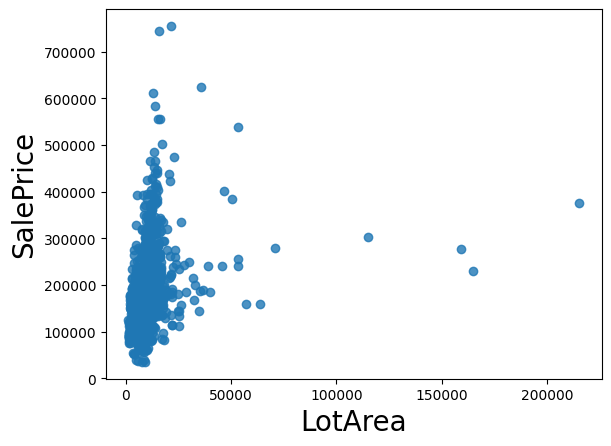

In [88]:
plt.scatter(data['LotArea'], data['SalePrice'],alpha=0.8)
plt.ylabel('SalePrice',size=20)
plt.xlabel('LotArea',size=20)
plt.show()
#This shows that as the lot area increases it does not always mean the sale pric will increase, in fact a house with over 200k lot area still does not correlate inot a high sale price. IT DOES NOT DIRECTLY CORRELATE

In [89]:
#Get Features
y= data['SalePrice']
x= data[["LotArea","OverallQual", "OverallCond", "YearBuilt","TotRmsAbvGrd","GarageArea"]]

<Axes: >

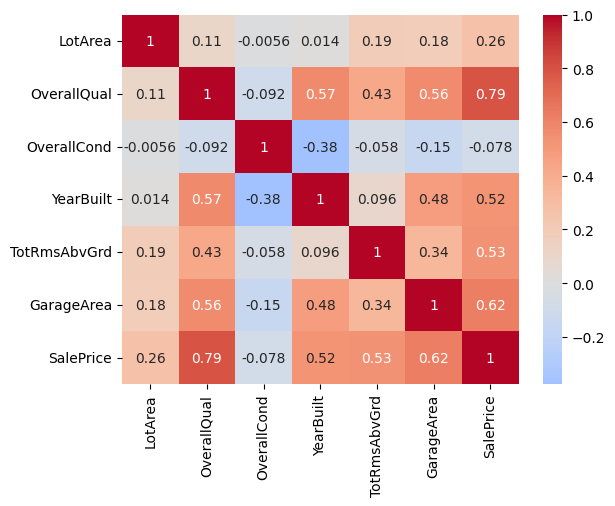

In [90]:
# Correlation Matrix
cont=["LotArea","OverallQual", "OverallCond", "YearBuilt","TotRmsAbvGrd","GarageArea","SalePrice"]
corr_matrix=pd.DataFrame(data[cont],columns=cont).corr()
sns.heatmap(corr_matrix, cmap='coolwarm',center=0, annot=True,fmt='.2g')
#This shows the correlation between these features. The SalePrice is highly correlated with OverallQual it seems like and is correlated a little with the year built, Garage Area, and total rooms above grade. It is not correlated much with the overall conditon and lot area which was seen in the graph above as well

In [91]:
#Modeling
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

(34900.0, 755000.0)

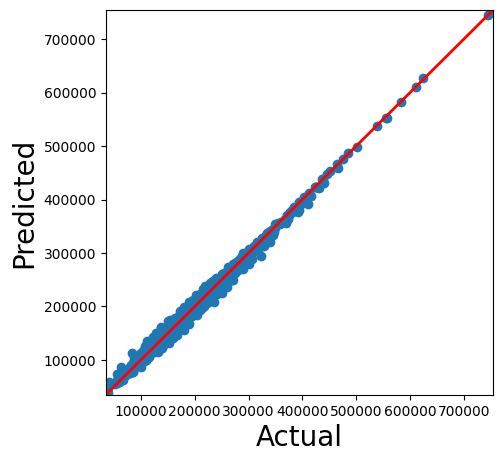

In [92]:
y_pred=model.predict(x)
plt.figure(figsize=(5,5))
plt.scatter(y,y_pred)
plt.plot([0,755000],[0,755000],color='r', linestyle='-', linewidth=2)
plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)
plt.xlim(34900, 755000)
plt.ylim(34900, 755000)
#This shows the predicted vs actual sale prices and it is not too far off compared to red line. This shows how well the model is making these predictions

In [93]:
#This will show us how it is making these predictions using SHAP
#Get SHAP Values
explainer=shap.Explainer(model)
shap_values =explainer(x)
np.shape(shap_values.values)
#This output tells us that there are 6 SHAP values for each of the 1460 observations; There is 1 SHAP Value for each model feature I included just to note

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(1460, 6)

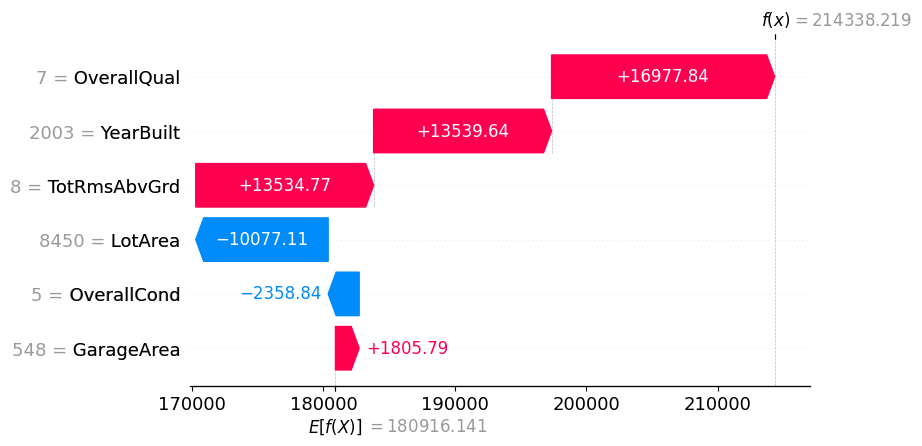

In [94]:
#Waterfall Plot: To visualize the SHAP values
shap.plots.waterfall(shap_values[0])
#The E[f(X)] number is the average predicted number of the Sale Price across all the 1460 observations
#The f(x) number is the predicted Sale Price value for this particular house on the line
#The numbers in the box are the SHAP values which tells us how each model feature has controbuted to the difference between the preditcion and the average prediction; blue means it is a less than and red means it is greater than (+)
#The numbers on the left in grey are the actual feature values; initial 

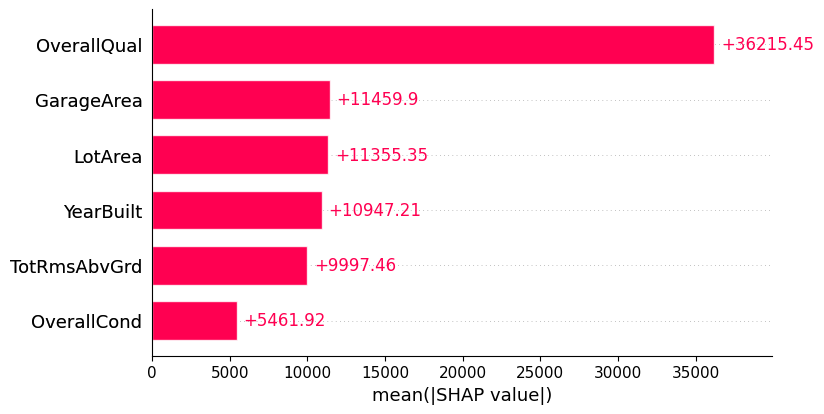

In [95]:
#Absoulte Mean SHAP: Bar graph
shap.plots.bar(shap_values)
#This takes the absolute value and averages it for each of my 6 features across all values down the column, so that + and - shap alues do not offset each other
#these are ranked in order from the largest mean SHAP value so Overall Quality of the house is largest average SHAP value; this has made a significant contribution to the models prediction

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


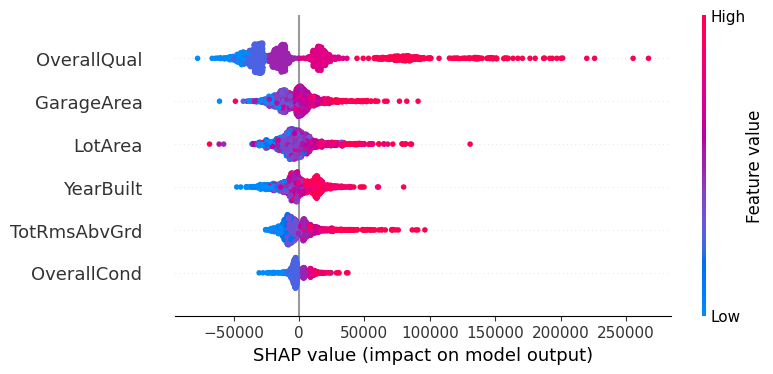

In [96]:
#THE MOST IMPORTANT PLOT: Beesswarm Plot
shap.plots.beeswarm(shap_values)
#This is a visualization of all of the SHAP values and can be used to determine the important relationships
#The color is determined by the deature value, which means higher values is a larger SHAP value positively and is red
#Just to note this is similar to the Bar graph above in the rankings; so again OverallQual is at the top; Another thing to notice is as the feature values increase the SHAP values increase for OverallQual

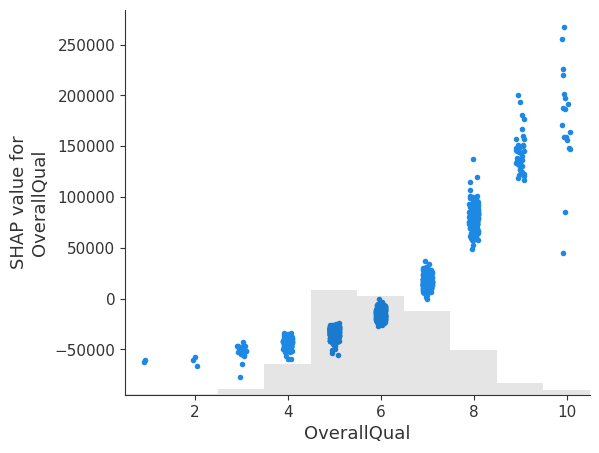

In [97]:
#Dependence Plot: scatter plot of the SHAP values vs the feature values for a single feature
shap.plots.scatter(shap_values[:,"OverallQual"])
#This shows it is not linear between the SHAP value of OverallQual and OverallQual even though in the above plot it may have seemed like so
#there is no steady increase, some values are sort of outliers

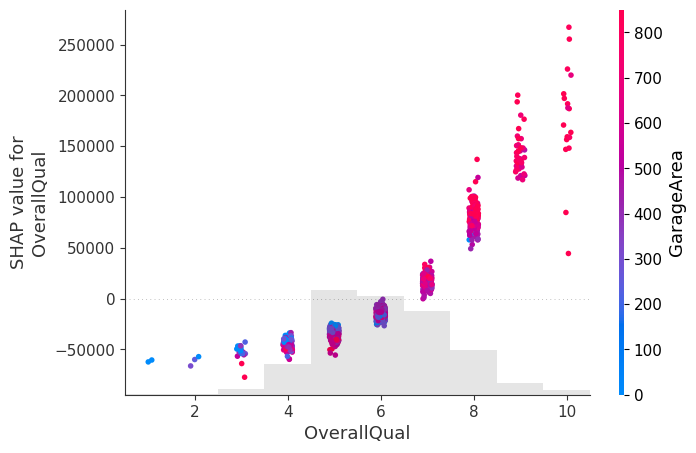

In [99]:
#We can also use the values for a second feature like the Garage Area, with color this time
shap.plots.scatter(shap_values[:,"OverallQual"],color=shap_values[:, "GarageArea"])
#Same plot as before but now the red points represent the a higher garage area value

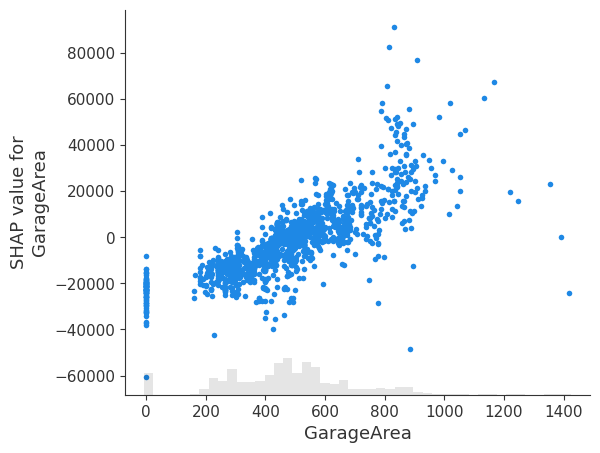

In [100]:
#Dependence plor for Garage Area to confirm what we saw in the beeswarm plots
shap.plots.scatter(shap_values[:,"GarageArea"])
#This tells us the values is a little more linear but is also full of many outliers that all over the place.

To conlcude it seems like the rankings for the best predictor for the sale price of a house from the features I have use is the rating out of ten given for the overall quality. The rating given for the overall condtion seems to be completly irrelevant to the sale price of the house.